## Toxic: LDA

Toxic words should be classified into one of six groups: Toxic, Severe Toxic, Obscene, Threat, Insult and Identity Hate. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim import corpora, models, similarities, matutils
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
df.head()

(159571, 18)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,rating,comment_text_s,comment_text_f,token_clean,sent_token,polarity_sentence,polarity_comment,polarity_comment_s,word_count,polarity_mean
idx,,,,,,,,,,,,,,,,,,
3a4c7758fad18de3,3a4c7758fad18de3,", I hope your retarded kids get anal raped and...",1,1,1,1,1,1,6,", I hope your retarded kids get anal raped and...",", hope retarded kids get anal raped murdered h...","[i, hope, your, retarded, kids, get, anal, rap...","[, I hope your retarded kids get anal raped an...","(-0.6, 1.0, -0.018750000000000003, [-0.4, -0.4...",0.00,0.00,94,-0.018750
24d2b50726b67167,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,6,I am going to murder ZimZalaBim ST47 for being...,", hope retarded kids get anal raped murdered h...","[i, am, going, to, murder, zimzalabim, st47, f...",[I am going to murder ZimZalaBim ST47 for bein...,"(-1.0, -1.0, -1.0, [-1.0])",0.00,0.00,12,-1.000000
c586b7a2fd575b13,c586b7a2fd575b13,"Shut up you asswipe, we don't care. I'll decap...",1,1,1,1,1,1,6,"Shut up you asswipe, we don't care. I'll decap...",", hope retarded kids get anal raped murdered h...","[shut, up, you, asswipe, we, dont, care, ill, ...","[Shut up you asswipe, we don't care., I'll dec...","(-0.2, 0.0, -0.07555555555555557, [0.0, -0.177...",-0.25,-0.25,24,-0.075556
77d84b1321c22d9a,77d84b1321c22d9a,"LGBT \n\nyou little fuck , are you a fag , tha...",1,1,1,1,1,1,6,"LGBT \n\nyou little fuck , are you a fag , tha...",", hope retarded kids get anal raped murdered h...","[lgbt, you, little, fuck, are, you, a, fag, th...","[LGBT \n\nyou little fuck , are you a fag , th...","(-0.17750000000000005, 0.0, -0.088750000000000...",0.00,0.00,56,-0.088750
1368c10281978876,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,6,"You're a stupid cunt \n\nFuck you dumb arse, y...",", hope retarded kids get anal raped murdered h...","[youre, a, stupid, cunt, fuck, you, dumb, arse...","[You're a stupid cunt \n\nFuck you dumb arse, ...","(-0.41250000000000003, -0.41250000000000003, -...",0.00,0.00,59,-0.412500


In [3]:
df_t = df[df['rating']>0]
df_nt = df[df['rating']==0]
print(df_t.shape, df_nt.shape)

(16225, 18) (143346, 18)


## Toxic Only

In [4]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 3),  stop_words='english', max_df=0.02, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(df_t.comment_text_s)
counts = count_vectorizer.transform(df_t.comment_text_s).transpose()
print(counts.shape)
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
print(len(id2word))

(275903, 16225)
275903


In [5]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10) # minimum_probability=0.03, 

2018-03-01 08:49:51,048 : INFO : using symmetric alpha at 0.16666666666666666
2018-03-01 08:49:51,053 : INFO : using symmetric eta at 0.16666666666666666
2018-03-01 08:49:51,254 : INFO : using serial LDA version on this node
2018-03-01 08:50:07,775 : INFO : running online (multi-pass) LDA training, 6 topics, 10 passes over the supplied corpus of 16225 documents, updating model once every 2000 documents, evaluating perplexity every 16225 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-01 08:50:07,814 : INFO : PROGRESS: pass 0, at document #2000/16225
2018-03-01 08:50:17,950 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:50:18,689 : INFO : topic #1 (0.167): 0.002*"piece" + 0.002*"mother" + 0.002*"piece shit" + 0.002*"bitches" + 0.001*"fucker" + 0.001*"penis" + 0.001*"die" + 0.001*"small" + 0.001*"hope" + 0.001*"fuck bitches"
2018-03-01 08:50:18,712 : INFO : topic #0 (0.167): 0.004*"nigger" + 0.003*"cock" + 0.002*"fat" 

2018-03-01 08:51:07,357 : INFO : topic #2 (0.167): 0.001*"shut" + 0.001*"admin" + 0.001*"fag" + 0.001*"nigger" + 0.001*"said" + 0.001*"reason" + 0.001*"leave" + 0.001*"ip" + 0.001*"hitler" + 0.001*"use"
2018-03-01 08:51:07,366 : INFO : topic #3 (0.167): 0.002*"personal" + 0.001*"attack" + 0.001*"bullshit" + 0.001*"doesn" + 0.001*"poop" + 0.001*"attacks" + 0.001*"vandalism" + 0.001*"nonsense" + 0.001*"editing" + 0.001*"source"
2018-03-01 08:51:07,375 : INFO : topic diff=0.663630, rho=0.408248
2018-03-01 08:51:07,427 : INFO : PROGRESS: pass 0, at document #14000/16225
2018-03-01 08:51:17,998 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:51:20,865 : INFO : topic #3 (0.167): 0.002*"personal" + 0.002*"attack" + 0.001*"wanker" + 0.001*"doesn" + 0.001*"vandalism" + 0.001*"editing" + 0.001*"attacks" + 0.001*"nonsense" + 0.001*"bullshit" + 0.001*"pages"
2018-03-01 08:51:20,875 : INFO : topic #4 (0.167): 0.002*"moron" + 0.002*"hi" + 0.001*"editing" + 

2018-03-01 08:51:49,382 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002*"fag" + 0.002*"nigger nigger" + 0.002*"nigger nigger nigger" + 0.002*"shut" + 0.001*"fag fag" + 0.001*"fag fag fag" + 0.001*"die" + 0.001*"dickhead" + 0.001*"shut fuck"
2018-03-01 08:51:49,388 : INFO : topic diff=0.406125, rho=0.314464
2018-03-01 08:51:49,453 : INFO : PROGRESS: pass 1, at document #8000/16225
2018-03-01 08:51:53,404 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:51:56,295 : INFO : topic #5 (0.167): 0.002*"retarded" + 0.001*"got" + 0.001*"old" + 0.001*"seriously" + 0.001*"lol" + 0.001*"suck suck" + 0.001*"ur" + 0.001*"sorry" + 0.001*"pathetic" + 0.001*"read"
2018-03-01 08:51:56,304 : INFO : topic #3 (0.167): 0.002*"personal" + 0.002*"bullshit" + 0.002*"attack" + 0.001*"fat" + 0.001*"doesn" + 0.001*"eat" + 0.001*"bullshit bullshit" + 0.001*"personal attack" + 0.001*"dumb" + 0.001*"editing"
2018-03-01 08:51:56,313 : INFO : topic #4 (0.167): 0.004*"fuck fuc

2018-03-01 08:52:26,761 : INFO : topic #2 (0.167): 0.001*"admin" + 0.001*"shut" + 0.001*"sick" + 0.001*"thanks" + 0.001*"following" + 0.001*"articles" + 0.001*"fag" + 0.001*"better" + 0.001*"editor" + 0.001*"using"
2018-03-01 08:52:26,772 : INFO : topic diff=0.221151, rho=0.314464
2018-03-01 08:52:26,812 : INFO : PROGRESS: pass 2, at document #2000/16225
2018-03-01 08:52:29,195 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:52:30,681 : INFO : topic #0 (0.167): 0.002*"cock" + 0.002*"ha" + 0.001*"nigger" + 0.001*"im" + 0.001*"fat" + 0.001*"kill" + 0.001*"damn" + 0.001*"big" + 0.001*"ur" + 0.001*"sock"
2018-03-01 08:52:30,688 : INFO : topic #1 (0.167): 0.001*"piece" + 0.001*"utc" + 0.001*"bias" + 0.001*"piece shit" + 0.001*"read" + 0.001*"feel" + 0.001*"care" + 0.001*"racist" + 0.001*"blocking" + 0.001*"need"
2018-03-01 08:52:30,695 : INFO : topic #4 (0.167): 0.004*"fuck fuck" + 0.003*"fuck fuck fuck" + 0.001*"moron" + 0.001*"editing" + 0.001*"b

2018-03-01 08:52:50,838 : INFO : topic #0 (0.167): 0.002*"ha" + 0.001*"cock" + 0.001*"ha ha" + 0.001*"care" + 0.001*"im" + 0.001*"fat" + 0.001*"big" + 0.001*"joke" + 0.001*"lol" + 0.001*"kill"
2018-03-01 08:52:50,853 : INFO : topic diff=0.269969, rho=0.299981
2018-03-01 08:52:50,924 : INFO : PROGRESS: pass 2, at document #14000/16225
2018-03-01 08:52:53,091 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:52:55,263 : INFO : topic #5 (0.167): 0.001*"retarded" + 0.001*"pig" + 0.001*"got" + 0.001*"rape" + 0.001*"pig pig pig" + 0.001*"old" + 0.001*"pig pig" + 0.001*"lol" + 0.001*"rape rape" + 0.001*"rape rape rape"
2018-03-01 08:52:55,271 : INFO : topic #3 (0.167): 0.002*"personal" + 0.002*"attack" + 0.001*"wanker" + 0.001*"attacks" + 0.001*"doesn" + 0.001*"personal attack" + 0.001*"nonsense" + 0.001*"vandalism" + 0.001*"wanker wanker" + 0.001*"pages"
2018-03-01 08:52:55,277 : INFO : topic #1 (0.167): 0.001*"utc" + 0.001*"care" + 0.001*"racist" + 0

2018-03-01 08:53:18,735 : INFO : topic #0 (0.167): 0.002*"cock" + 0.001*"ha" + 0.001*"fat" + 0.001*"big" + 0.001*"kill" + 0.001*"im" + 0.001*"nigger" + 0.001*"piece" + 0.001*"joke" + 0.001*"bastard"
2018-03-01 08:53:18,745 : INFO : topic diff=0.240745, rho=0.287331
2018-03-01 08:53:18,792 : INFO : PROGRESS: pass 3, at document #8000/16225
2018-03-01 08:53:21,232 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:53:24,226 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002*"nigger nigger" + 0.002*"nigger nigger nigger" + 0.002*"shut" + 0.002*"fag" + 0.001*"thanks" + 0.001*"leave" + 0.001*"admin" + 0.001*"said" + 0.001*"die"
2018-03-01 08:53:24,238 : INFO : topic #5 (0.167): 0.002*"retarded" + 0.001*"got" + 0.001*"suck suck" + 0.001*"old" + 0.001*"seriously" + 0.001*"lol" + 0.001*"ur" + 0.001*"read" + 0.001*"pathetic" + 0.001*"suck suck suck"
2018-03-01 08:53:24,259 : INFO : topic #4 (0.167): 0.004*"fuck fuck" + 0.002*"fuck fuck fuck" + 0.002*"moron

2018-03-01 08:53:50,862 : INFO : topic #4 (0.167): 0.002*"moron" + 0.001*"sex" + 0.001*"hi" + 0.001*"editing" + 0.001*"http" + 0.001*"comment" + 0.001*"balls" + 0.001*"pages" + 0.001*"com" + 0.001*"jerk"
2018-03-01 08:53:50,874 : INFO : topic diff=0.121159, rho=0.287331
2018-03-01 08:53:50,925 : INFO : PROGRESS: pass 4, at document #2000/16225
2018-03-01 08:53:53,227 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:53:54,881 : INFO : topic #0 (0.167): 0.002*"cock" + 0.002*"ha" + 0.001*"nigger" + 0.001*"fat" + 0.001*"kill" + 0.001*"im" + 0.001*"damn" + 0.001*"sock" + 0.001*"ur" + 0.001*"joke"
2018-03-01 08:53:54,890 : INFO : topic #3 (0.167): 0.003*"personal" + 0.002*"attack" + 0.001*"personal attack" + 0.001*"attacks" + 0.001*"eat" + 0.001*"come" + 0.001*"vandalism" + 0.001*"sources" + 0.001*"personal attacks" + 0.001*"doesn"
2018-03-01 08:53:54,899 : INFO : topic #1 (0.167): 0.001*"piece" + 0.001*"bias" + 0.001*"read" + 0.001*"piece shit" + 0.

2018-03-01 08:54:13,754 : INFO : topic #4 (0.167): 0.002*"fuck fuck" + 0.002*"moron" + 0.002*"hi" + 0.002*"fuck fuck fuck" + 0.001*"penis" + 0.001*"moron hi" + 0.001*"hi moron hi" + 0.001*"hi moron" + 0.001*"http" + 0.001*"moron hi moron"
2018-03-01 08:54:13,761 : INFO : topic diff=0.192332, rho=0.276158
2018-03-01 08:54:13,806 : INFO : PROGRESS: pass 4, at document #14000/16225
2018-03-01 08:54:15,876 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:54:18,191 : INFO : topic #5 (0.167): 0.001*"retarded" + 0.001*"pig" + 0.001*"rape" + 0.001*"got" + 0.001*"pig pig" + 0.001*"pig pig pig" + 0.001*"old" + 0.001*"lol" + 0.001*"rape rape" + 0.001*"rape rape rape"
2018-03-01 08:54:18,199 : INFO : topic #2 (0.167): 0.001*"nigger" + 0.001*"shut" + 0.001*"fag" + 0.001*"admin" + 0.001*"using" + 0.001*"said" + 0.001*"ip" + 0.001*"leave" + 0.001*"better" + 0.001*"nigger nigger"
2018-03-01 08:54:18,205 : INFO : topic #0 (0.167): 0.002*"ha" + 0.001*"cock" + 0.

2018-03-01 08:54:40,361 : INFO : topic #3 (0.167): 0.002*"personal" + 0.001*"fat" + 0.001*"attack" + 0.001*"eat" + 0.001*"wanker" + 0.001*"jew" + 0.001*"dumb" + 0.001*"personal attack" + 0.001*"attacks" + 0.001*"source"
2018-03-01 08:54:40,370 : INFO : topic diff=0.208194, rho=0.266194
2018-03-01 08:54:40,409 : INFO : PROGRESS: pass 5, at document #8000/16225
2018-03-01 08:54:42,179 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:54:44,088 : INFO : topic #4 (0.167): 0.004*"fuck fuck" + 0.002*"fuck fuck fuck" + 0.002*"moron" + 0.001*"hi" + 0.001*"penis" + 0.001*"http" + 0.001*"moron hi" + 0.001*"hi moron" + 0.001*"hi moron hi" + 0.001*"editing"
2018-03-01 08:54:44,097 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002*"nigger nigger" + 0.002*"nigger nigger nigger" + 0.002*"fag" + 0.002*"shut" + 0.001*"thanks" + 0.001*"leave" + 0.001*"admin" + 0.001*"said" + 0.001*"shut fuck"
2018-03-01 08:54:44,108 : INFO : topic #3 (0.167): 0.002*"personal" + 0

2018-03-01 08:55:19,452 : INFO : topic #4 (0.167): 0.002*"moron" + 0.001*"hi" + 0.001*"sex" + 0.001*"http" + 0.001*"editing" + 0.001*"fuck fuck" + 0.001*"comment" + 0.001*"pages" + 0.001*"balls" + 0.001*"com"
2018-03-01 08:55:19,458 : INFO : topic diff=0.103272, rho=0.266194
2018-03-01 08:55:19,504 : INFO : PROGRESS: pass 6, at document #2000/16225
2018-03-01 08:55:21,603 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:55:23,465 : INFO : topic #5 (0.167): 0.003*"retarded" + 0.002*"retarded retarded" + 0.002*"retarded retarded retarded" + 0.001*"retardedyour" + 0.001*"got" + 0.001*"seriously" + 0.001*"pig" + 0.001*"gay gay" + 0.001*"yo" + 0.001*"actually"
2018-03-01 08:55:23,474 : INFO : topic #1 (0.167): 0.001*"piece" + 0.001*"bias" + 0.001*"read" + 0.001*"utc" + 0.001*"care" + 0.001*"piece shit" + 0.001*"blocking" + 0.001*"need" + 0.001*"racist" + 0.001*"maybe"
2018-03-01 08:55:23,482 : INFO : topic #0 (0.167): 0.002*"ha" + 0.002*"cock" + 0.0

2018-03-01 08:55:43,871 : INFO : topic #4 (0.167): 0.002*"fuck fuck" + 0.002*"moron" + 0.002*"hi" + 0.002*"fuck fuck fuck" + 0.001*"penis" + 0.001*"moron hi" + 0.001*"hi moron hi" + 0.001*"hi moron" + 0.001*"http" + 0.001*"moron hi moron"
2018-03-01 08:55:43,878 : INFO : topic diff=0.170501, rho=0.257236
2018-03-01 08:55:43,927 : INFO : PROGRESS: pass 6, at document #14000/16225
2018-03-01 08:55:45,627 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:55:48,074 : INFO : topic #3 (0.167): 0.002*"personal" + 0.001*"attack" + 0.001*"wanker" + 0.001*"attacks" + 0.001*"personal attack" + 0.001*"nonsense" + 0.001*"doesn" + 0.001*"vandalism" + 0.001*"bullshit" + 0.001*"source"
2018-03-01 08:55:48,082 : INFO : topic #0 (0.167): 0.002*"ha" + 0.001*"cock" + 0.001*"ha ha" + 0.001*"care" + 0.001*"joke" + 0.001*"im" + 0.001*"sock" + 0.001*"big" + 0.001*"kill" + 0.001*"got"
2018-03-01 08:55:48,097 : INFO : topic #5 (0.167): 0.001*"retarded" + 0.001*"pig" + 0.

2018-03-01 08:56:10,619 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002*"nigger nigger" + 0.002*"fag" + 0.002*"nigger nigger nigger" + 0.002*"shut" + 0.001*"fag fag" + 0.001*"shut fuck" + 0.001*"fag fag fag" + 0.001*"dickhead" + 0.001*"die"
2018-03-01 08:56:10,625 : INFO : topic diff=0.190836, rho=0.249126
2018-03-01 08:56:10,672 : INFO : PROGRESS: pass 7, at document #8000/16225
2018-03-01 08:56:13,266 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:56:15,400 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002*"nigger nigger" + 0.002*"nigger nigger nigger" + 0.002*"fag" + 0.002*"shut" + 0.001*"thanks" + 0.001*"leave" + 0.001*"admin" + 0.001*"said" + 0.001*"shut fuck"
2018-03-01 08:56:15,409 : INFO : topic #0 (0.167): 0.002*"cock" + 0.002*"ha" + 0.001*"fat" + 0.001*"big" + 0.001*"kill" + 0.001*"ha ha" + 0.001*"im" + 0.001*"shit shit" + 0.001*"piece" + 0.001*"joke"
2018-03-01 08:56:15,425 : INFO : topic #5 (0.167): 0.002*"retarded" + 0.001*"got

2018-03-01 08:56:39,913 : INFO : topic #3 (0.167): 0.003*"personal" + 0.002*"attack" + 0.001*"personal attack" + 0.001*"attacks" + 0.001*"sources" + 0.001*"personal attacks" + 0.001*"vandalism" + 0.001*"come" + 0.001*"pages" + 0.001*"doesn"
2018-03-01 08:56:39,923 : INFO : topic diff=0.094340, rho=0.249126
2018-03-01 08:56:39,969 : INFO : PROGRESS: pass 8, at document #2000/16225
2018-03-01 08:56:41,999 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:56:43,589 : INFO : topic #5 (0.167): 0.003*"retarded" + 0.002*"retarded retarded" + 0.002*"retarded retarded retarded" + 0.001*"retardedyour" + 0.001*"got" + 0.001*"seriously" + 0.001*"pig" + 0.001*"gay gay" + 0.001*"lol" + 0.001*"yo"
2018-03-01 08:56:43,594 : INFO : topic #0 (0.167): 0.002*"ha" + 0.002*"cock" + 0.001*"nigger" + 0.001*"kill" + 0.001*"fat" + 0.001*"im" + 0.001*"damn" + 0.001*"sock" + 0.001*"joke" + 0.001*"ur"
2018-03-01 08:56:43,603 : INFO : topic #2 (0.167): 0.003*"nigger" + 0.002

2018-03-01 08:57:08,794 : INFO : topic diff=0.155986, rho=0.241737
2018-03-01 08:57:08,889 : INFO : PROGRESS: pass 8, at document #14000/16225
2018-03-01 08:57:12,379 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:57:16,310 : INFO : topic #1 (0.167): 0.001*"utc" + 0.001*"care" + 0.001*"racist" + 0.001*"bum" + 0.001*"hate hate" + 0.001*"twat" + 0.001*"piece" + 0.001*"feel" + 0.001*"read" + 0.001*"look"
2018-03-01 08:57:16,334 : INFO : topic #5 (0.167): 0.001*"retarded" + 0.001*"pig" + 0.001*"got" + 0.001*"rape" + 0.001*"pig pig" + 0.001*"old" + 0.001*"pig pig pig" + 0.001*"lol" + 0.001*"seriously" + 0.001*"rape rape"
2018-03-01 08:57:16,342 : INFO : topic #0 (0.167): 0.002*"ha" + 0.001*"cock" + 0.001*"ha ha" + 0.001*"care" + 0.001*"joke" + 0.001*"im" + 0.001*"sock" + 0.001*"big" + 0.001*"kill" + 0.001*"fat"
2018-03-01 08:57:16,360 : INFO : topic #3 (0.167): 0.002*"personal" + 0.001*"attack" + 0.001*"wanker" + 0.001*"attacks" + 0.001*"personal 

2018-03-01 08:58:07,719 : INFO : topic diff=0.177459, rho=0.234969
2018-03-01 08:58:07,998 : INFO : PROGRESS: pass 9, at document #8000/16225
2018-03-01 08:58:16,132 : INFO : merging changes from 2000 documents into a model of 16225 documents
2018-03-01 08:58:26,229 : INFO : topic #3 (0.167): 0.002*"personal" + 0.001*"attack" + 0.001*"fat" + 0.001*"bullshit" + 0.001*"personal attack" + 0.001*"eat" + 0.001*"doesn" + 0.001*"attacks" + 0.001*"come" + 0.001*"editing"
2018-03-01 08:58:26,262 : INFO : topic #5 (0.167): 0.002*"retarded" + 0.001*"got" + 0.001*"suck suck" + 0.001*"old" + 0.001*"lol" + 0.001*"seriously" + 0.001*"retarded retarded" + 0.001*"ur" + 0.001*"retarded retarded retarded" + 0.001*"read"
2018-03-01 08:58:26,321 : INFO : topic #4 (0.167): 0.004*"fuck fuck" + 0.002*"fuck fuck fuck" + 0.002*"moron" + 0.001*"hi" + 0.001*"penis" + 0.001*"http" + 0.001*"editing" + 0.001*"moron hi" + 0.001*"hi moron" + 0.001*"hi moron hi"
2018-03-01 08:58:26,342 : INFO : topic #1 (0.167): 0.001*

2018-03-01 08:59:46,264 : INFO : topic diff=0.087747, rho=0.234969


In [6]:
topics = lda.print_topics(num_words=200)
topics

2018-03-01 08:59:46,516 : INFO : topic #0 (0.167): 0.002*"ha" + 0.001*"joke" + 0.001*"sock" + 0.001*"im" + 0.001*"pretty" + 0.001*"ha ha" + 0.001*"puppet" + 0.001*"cock" + 0.001*"yeah" + 0.001*"guys" + 0.001*"vandalism" + 0.001*"let" + 0.001*"sock puppet" + 0.001*"got" + 0.001*"damn" + 0.001*"care" + 0.001*"leave" + 0.001*"fan" + 0.001*"lol" + 0.001*"picture" + 0.001*"idiots" + 0.001*"troll" + 0.001*"big" + 0.001*"harassment" + 0.001*"loser" + 0.001*"obvious" + 0.001*"wrong" + 0.001*"does" + 0.001*"called" + 0.001*"job" + 0.001*"left" + 0.001*"wow" + 0.001*"real" + 0.000*"kill" + 0.000*"mean" + 0.000*"tell" + 0.000*"said" + 0.000*"person" + 0.000*"protected" + 0.000*"utc" + 0.000*"sure" + 0.000*"ask" + 0.000*"better" + 0.000*"mentioned" + 0.000*"come" + 0.000*"pages" + 0.000*"fat" + 0.000*"editors" + 0.000*"ha ha ha" + 0.000*"ridiculous" + 0.000*"admin" + 0.000*"editing" + 0.000*"false" + 0.000*"im gay" + 0.000*"case" + 0.000*"don delete" + 0.000*"bother" + 0.000*"user talk" + 0.000*"c

2018-03-01 08:59:46,586 : INFO : topic #3 (0.167): 0.003*"personal" + 0.002*"attack" + 0.001*"personal attack" + 0.001*"attacks" + 0.001*"sources" + 0.001*"personal attacks" + 0.001*"vandalism" + 0.001*"come" + 0.001*"doesn" + 0.001*"reliable" + 0.001*"pages" + 0.001*"source" + 0.001*"look" + 0.001*"link" + 0.001*"nonsense" + 0.001*"sorry" + 0.001*"does" + 0.001*"articles" + 0.001*"talking" + 0.001*"aids" + 0.001*"poop" + 0.001*"wanker" + 0.001*"wrong" + 0.001*"says" + 0.001*"editing" + 0.001*"spam" + 0.001*"information" + 0.001*"making" + 0.001*"hypocrite" + 0.001*"site" + 0.001*"mean" + 0.001*"doing" + 0.001*"said" + 0.001*"used" + 0.001*"deleted" + 0.001*"editor" + 0.001*"administrator" + 0.001*"wasn" + 0.001*"bloody" + 0.001*"posts" + 0.001*"new" + 0.001*"bullshit" + 0.001*"removed" + 0.001*"ridiculous" + 0.001*"point" + 0.001*"public" + 0.001*"talk pages" + 0.001*"liar" + 0.000*"greek" + 0.000*"fact" + 0.000*"eat" + 0.000*"image" + 0.000*"revert" + 0.000*"person" + 0.000*"need" + 

[(0,
  '0.002*"ha" + 0.001*"joke" + 0.001*"sock" + 0.001*"im" + 0.001*"pretty" + 0.001*"ha ha" + 0.001*"puppet" + 0.001*"cock" + 0.001*"yeah" + 0.001*"guys" + 0.001*"vandalism" + 0.001*"let" + 0.001*"sock puppet" + 0.001*"got" + 0.001*"damn" + 0.001*"care" + 0.001*"leave" + 0.001*"fan" + 0.001*"lol" + 0.001*"picture" + 0.001*"idiots" + 0.001*"troll" + 0.001*"big" + 0.001*"harassment" + 0.001*"loser" + 0.001*"obvious" + 0.001*"wrong" + 0.001*"does" + 0.001*"called" + 0.001*"job" + 0.001*"left" + 0.001*"wow" + 0.001*"real" + 0.000*"kill" + 0.000*"mean" + 0.000*"tell" + 0.000*"said" + 0.000*"person" + 0.000*"protected" + 0.000*"utc" + 0.000*"sure" + 0.000*"ask" + 0.000*"better" + 0.000*"mentioned" + 0.000*"come" + 0.000*"pages" + 0.000*"fat" + 0.000*"editors" + 0.000*"ha ha ha" + 0.000*"ridiculous" + 0.000*"admin" + 0.000*"editing" + 0.000*"false" + 0.000*"im gay" + 0.000*"case" + 0.000*"don delete" + 0.000*"bother" + 0.000*"user talk" + 0.000*"crap" + 0.000*"question" + 0.000*"study" + 0

In [7]:
type(topics)

list

In [8]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [9]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [10]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[0:15]

[[(0, 0.05599866), (1, 0.84300566), (5, 0.09165335)],
 [(0, 0.9441564),
  (1, 0.011167382),
  (2, 0.011186284),
  (3, 0.011183045),
  (4, 0.011140837),
  (5, 0.011166064)],
 [(1, 0.06267533), (4, 0.92244524)],
 [(2, 0.0638135), (5, 0.920251)],
 [(2, 0.94628197), (5, 0.037362278)],
 [(0, 0.83370686), (5, 0.14245577)],
 [(1, 0.92283404), (2, 0.06379854)],
 [(1, 0.9814204)],
 [(0, 0.90161496), (3, 0.06322318)],
 [(0, 0.69286937),
  (1, 0.010423182),
  (2, 0.010432219),
  (3, 0.26542246),
  (4, 0.01042765),
  (5, 0.010425147)],
 [(2, 0.9163166), (3, 0.07102783)],
 [(1, 0.98096794)],
 [(2, 0.030692434), (3, 0.06364892), (5, 0.89693373)],
 [(0, 0.91831887), (2, 0.06572286)],
 [(4, 0.9794959)]]

In [11]:
df.comment_text[5]

"and your little faggot boy Propol, pray, pray little wonk that I don't find your little ass and kill you"

In [12]:
lda.log_perplexity

<bound method LdaModel.log_perplexity of <gensim.models.ldamodel.LdaModel object at 0x108585f60>>

(0, '0.002*"ha" + 0.001*"joke" + 0.001*"sock" + 0.001*"im" + 0.001*"pretty" + 0.001*"ha ha" + 0.001*"puppet" + 0.001*"cock" + 0.001*"yeah" + 0.001*"guys" + 0.001*"vandalism" + 0.001*"let" + 0.001*"sock puppet" + 0.001*"got" + 0.001*"damn" + 0.001*"care" + 0.001*"leave" + 0.001*"fan" + 0.001*"lol" + 0.001*"picture" + 0.001*"idiots" + 0.001*"troll" + 0.001*"big" + 0.001*"harassment" + 0.001*"loser" + 0.001*"obvious" + 0.001*"wrong" + 0.001*"does" + 0.001*"called" + 0.001*"job" + 0.001*"left" + 0.001*"wow" + 0.001*"real" + 0.000*"kill" + 0.000*"mean" + 0.000*"tell" + 0.000*"said" + 0.000*"person" + 0.000*"protected" + 0.000*"utc" + 0.000*"sure" + 0.000*"ask" + 0.000*"better" + 0.000*"mentioned" + 0.000*"come" + 0.000*"pages" + 0.000*"fat" + 0.000*"editors" + 0.000*"ha ha ha" + 0.000*"ridiculous" + 0.000*"admin" + 0.000*"editing" + 0.000*"false" + 0.000*"im gay" + 0.000*"case" + 0.000*"don delete" + 0.000*"bother" + 0.000*"user talk" + 0.000*"crap" + 0.000*"question" + 0.000*"study" + 0.00

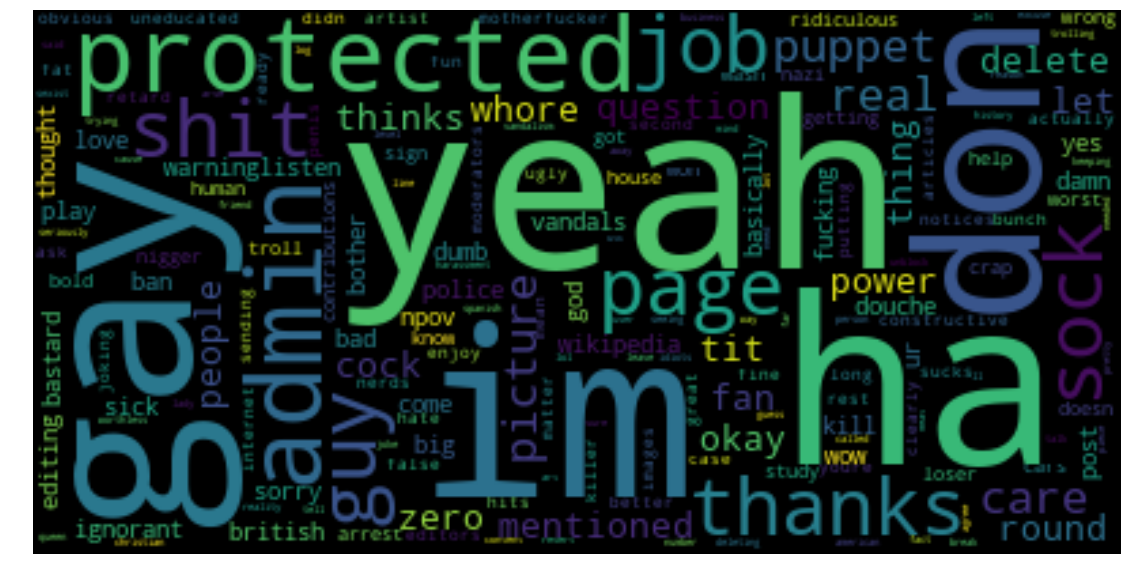

(1, '0.001*"bias" + 0.001*"read" + 0.001*"utc" + 0.001*"care" + 0.001*"need" + 0.001*"blocking" + 0.001*"look" + 0.001*"prove" + 0.001*"work" + 0.001*"feel" + 0.001*"maybe" + 0.001*"real" + 0.001*"rules" + 0.001*"day" + 0.001*"sockpuppet" + 0.001*"piece" + 0.001*"guy" + 0.001*"policy" + 0.001*"racist" + 0.001*"let" + 0.001*"true" + 0.001*"vandalism" + 0.001*"instead" + 0.001*"hate hate" + 0.001*"liar" + 0.001*"wp" + 0.001*"nazi" + 0.001*"racism" + 0.001*"discussion" + 0.001*"hello" + 0.001*"don think" + 0.001*"country" + 0.001*"idiotic" + 0.001*"threats" + 0.001*"anti" + 0.001*"contributions" + 0.001*"editing" + 0.001*"trying" + 0.001*"chance" + 0.001*"write" + 0.000*"hate hate hate" + 0.000*"respect" + 0.000*"censor" + 0.000*"twat" + 0.000*"news" + 0.000*"doing" + 0.000*"section" + 0.000*"mean" + 0.000*"wtf" + 0.000*"try" + 0.000*"speak" + 0.000*"computer" + 0.000*"people like" + 0.000*"send" + 0.000*"dvd" + 0.000*"ing" + 0.000*"bad" + 0.000*"crap" + 0.000*"clear" + 0.000*"way" + 0.00

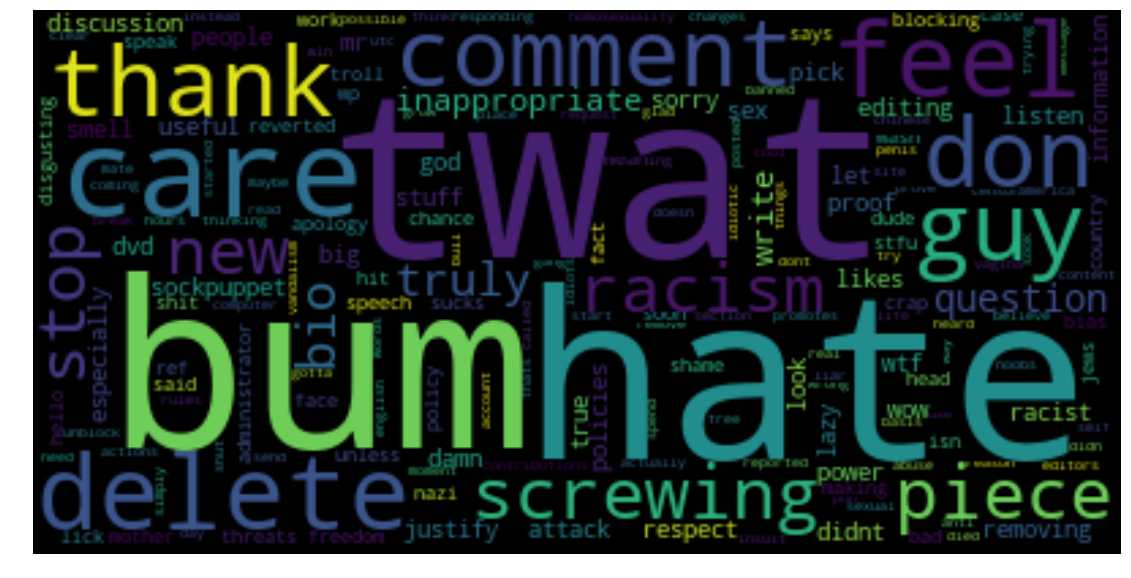

(2, '0.001*"fag" + 0.001*"shut" + 0.001*"thanks" + 0.001*"admin" + 0.001*"sick" + 0.001*"following" + 0.001*"articles" + 0.001*"using" + 0.001*"ip" + 0.001*"better" + 0.001*"leave" + 0.001*"nigger" + 0.001*"comments" + 0.001*"editor" + 0.001*"feel" + 0.001*"help" + 0.001*"used" + 0.001*"said" + 0.001*"reply" + 0.001*"band" + 0.001*"sorry" + 0.001*"use" + 0.001*"dear" + 0.001*"die" + 0.001*"look" + 0.001*"away" + 0.001*"im" + 0.001*"clearly" + 0.001*"place" + 0.001*"reference" + 0.001*"address" + 0.001*"pages" + 0.001*"post" + 0.001*"comment" + 0.001*"defend" + 0.001*"wrong" + 0.001*"bad" + 0.001*"yo" + 0.001*"come" + 0.001*"reason" + 0.000*"getting" + 0.000*"way" + 0.000*"truth" + 0.000*"does" + 0.000*"nigger nigger" + 0.000*"things" + 0.000*"evil" + 0.000*"posted" + 0.000*"vandalism" + 0.000*"encyclopedia" + 0.000*"tell" + 0.000*"note" + 0.000*"valid" + 0.000*"nigger nigger nigger" + 0.000*"ip address" + 0.000*"hi" + 0.000*"wales" + 0.000*"hours" + 0.000*"white" + 0.000*"need" + 0.000

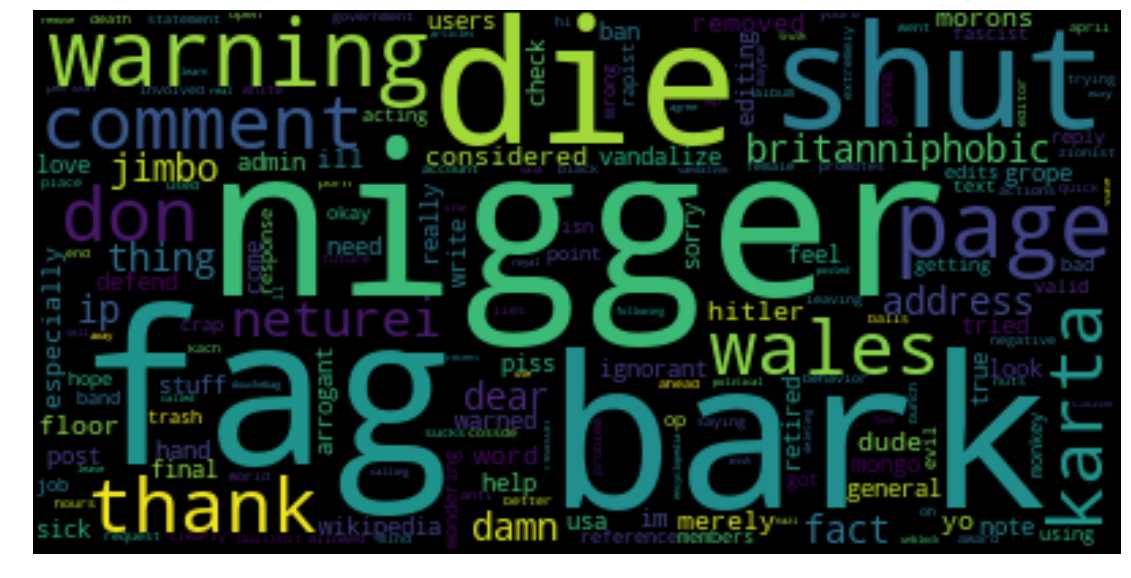

(3, '0.003*"personal" + 0.002*"attack" + 0.001*"personal attack" + 0.001*"attacks" + 0.001*"sources" + 0.001*"personal attacks" + 0.001*"vandalism" + 0.001*"come" + 0.001*"doesn" + 0.001*"reliable" + 0.001*"pages" + 0.001*"source" + 0.001*"look" + 0.001*"link" + 0.001*"nonsense" + 0.001*"sorry" + 0.001*"does" + 0.001*"articles" + 0.001*"talking" + 0.001*"aids" + 0.001*"poop" + 0.001*"wanker" + 0.001*"wrong" + 0.001*"says" + 0.001*"editing" + 0.001*"spam" + 0.001*"information" + 0.001*"making" + 0.001*"hypocrite" + 0.001*"site" + 0.001*"mean" + 0.001*"doing" + 0.001*"said" + 0.001*"used" + 0.001*"deleted" + 0.001*"editor" + 0.001*"administrator" + 0.001*"wasn" + 0.001*"bloody" + 0.001*"posts" + 0.001*"new" + 0.001*"bullshit" + 0.001*"removed" + 0.001*"ridiculous" + 0.001*"point" + 0.001*"public" + 0.001*"talk pages" + 0.001*"liar" + 0.000*"greek" + 0.000*"fact" + 0.000*"eat" + 0.000*"image" + 0.000*"revert" + 0.000*"person" + 0.000*"need" + 0.000*"wanker wanker" + 0.000*"lies" + 0.000*"

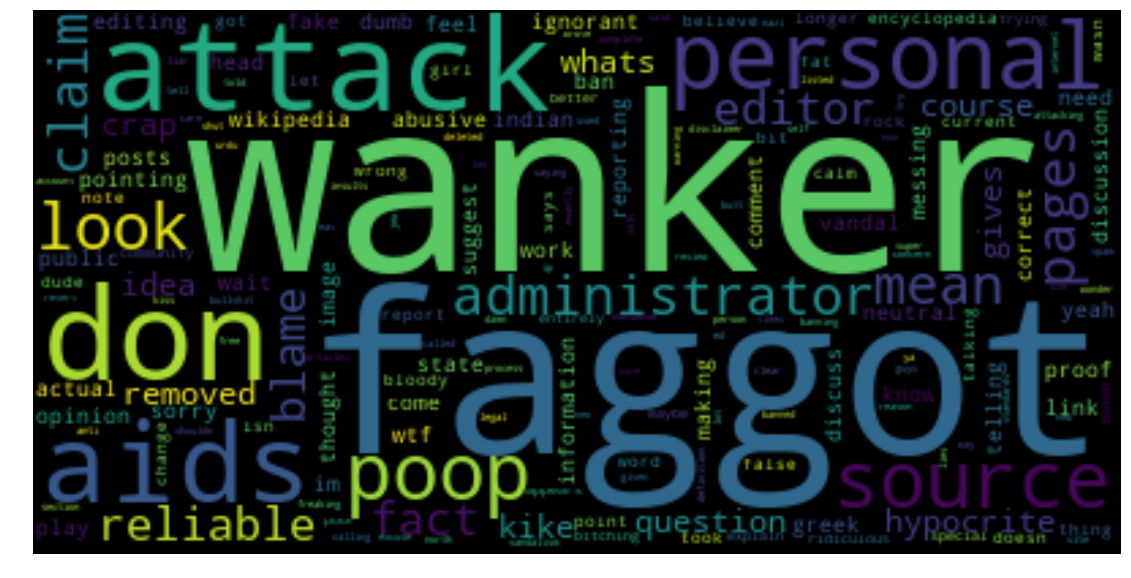

(4, '0.002*"moron" + 0.001*"hi" + 0.001*"fuck fuck" + 0.001*"sex" + 0.001*"http" + 0.001*"editing" + 0.001*"pages" + 0.001*"comment" + 0.001*"com" + 0.001*"jerk" + 0.001*"balls" + 0.001*"let" + 0.001*"fuck fuck fuck" + 0.001*"blah" + 0.001*"articles" + 0.001*"fool" + 0.001*"way" + 0.001*"moron hi" + 0.001*"hi moron hi" + 0.001*"hi moron" + 0.001*"accusations" + 0.001*"moron hi moron" + 0.001*"penis" + 0.001*"come" + 0.001*"www" + 0.001*"things" + 0.001*"try" + 0.001*"deleted" + 0.001*"work" + 0.001*"harassing" + 0.001*"http www" + 0.000*"biased" + 0.000*"happen" + 0.000*"chinese" + 0.000*"org" + 0.000*"notable" + 0.000*"offensive" + 0.000*"isn" + 0.000*"en" + 0.000*"game" + 0.000*"big" + 0.000*"thought" + 0.000*"feelings" + 0.000*"person" + 0.000*"properly" + 0.000*"running" + 0.000*"trying" + 0.000*"fellow" + 0.000*"sound" + 0.000*"balls balls" + 0.000*"look" + 0.000*"added" + 0.000*"wikipedia org" + 0.000*"hater" + 0.000*"blah blah" + 0.000*"love" + 0.000*"god" + 0.000*"balls balls b

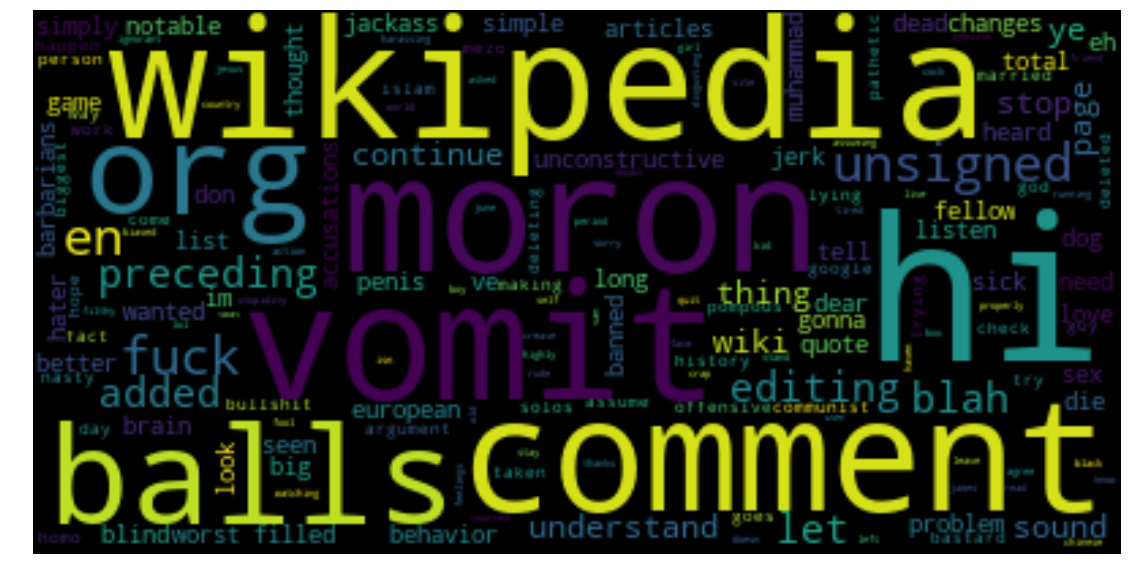

(5, '0.004*"retarded" + 0.002*"retarded retarded" + 0.002*"retarded retarded retarded" + 0.001*"retardedyour" + 0.001*"got" + 0.001*"seriously" + 0.001*"lol" + 0.001*"actually" + 0.001*"pig" + 0.001*"retarded retardedyour" + 0.001*"retardedyour retarded" + 0.001*"seen" + 0.001*"old" + 0.001*"language" + 0.001*"ok" + 0.001*"read" + 0.001*"certainly" + 0.001*"ignore" + 0.001*"saying" + 0.001*"lie" + 0.001*"bad" + 0.001*"war" + 0.001*"gay gay" + 0.001*"rape" + 0.001*"didn" + 0.001*"retardedyour retarded retardedyour" + 0.001*"retardedyour retardedyour" + 0.001*"retardedyour retardedyour retarded" + 0.001*"retarded retardedyour retardedyour" + 0.001*"yo" + 0.001*"dead" + 0.001*"pathetic" + 0.001*"propaganda" + 0.001*"gone" + 0.001*"gay gay gay" + 0.001*"metal" + 0.000*"civil" + 0.000*"mentally" + 0.000*"pig pig" + 0.000*"fraud" + 0.000*"thing" + 0.000*"trying" + 0.000*"based" + 0.000*"looks" + 0.000*"pig pig pig" + 0.000*"terrorists" + 0.000*"sorry" + 0.000*"hide" + 0.000*"need" + 0.000*"r

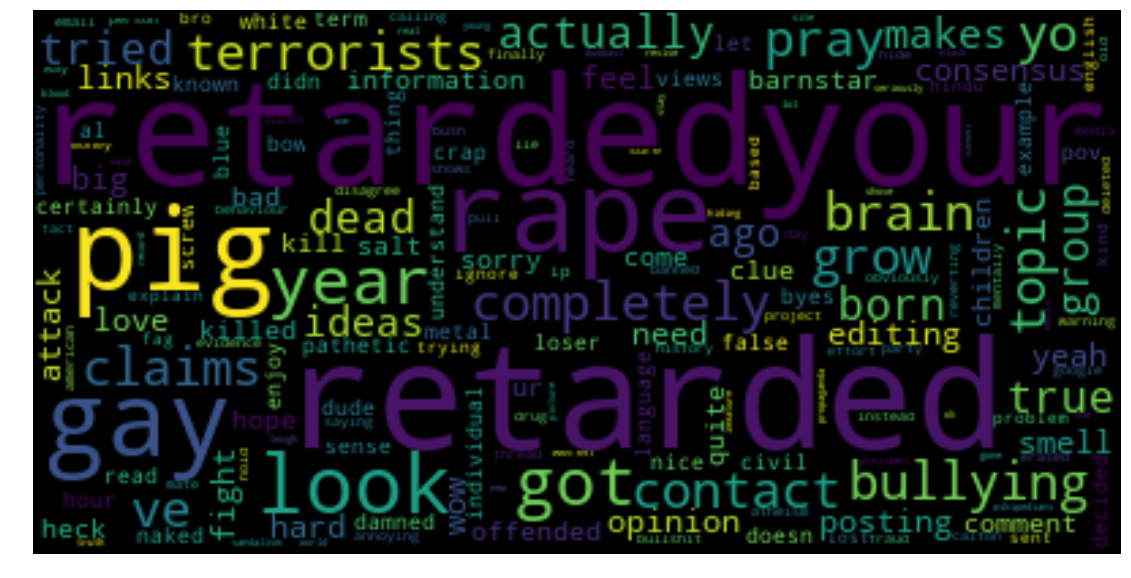

In [13]:
for topic in topics:
    print(topic)
    wordcloud = WordCloud(max_words=200).generate(topic[1])
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
# https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
categories = ['clean','toxic','severe_toxic','obscene','threat','insult','identity_hate']

for category in categories:
    if category == 'clean':
        doc = df_nt
    else:
        doc = df_t[df_t[category]==1]
    count_vectorizer = CountVectorizer(ngram_range=(1, 3),  stop_words='english',max_df=0.02, token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit(doc.comment_text_s)
    counts = count_vectorizer.transform(doc.comment_text_s).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    
    lda = models.LdaModel(corpus=corpus, num_topics=1, id2word=id2word, passes=10) # minimum_probability=0.03, 
    topics = lda.print_topics(num_words=2000)

    print("Category: " + category)
    for topic in topics:
        wordcloud = WordCloud(max_words=2000).generate(topic[1])
        plt.figure(figsize=(20,10))
        plt.imshow(wordcloud,interpolation='bilinear')
        plt.savefig('wordcloud' + category + '_1.png')
        plt.axis("off")
        plt.show()

2018-03-01 10:30:48,808 : INFO : using symmetric alpha at 1.0
2018-03-01 10:30:48,889 : INFO : using symmetric eta at 1.0
2018-03-01 10:30:51,457 : INFO : using serial LDA version on this node
2018-03-01 10:31:20,330 : INFO : running online (multi-pass) LDA training, 1 topics, 10 passes over the supplied corpus of 143346 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-01 10:31:20,514 : INFO : PROGRESS: pass 0, at document #2000/143346
2018-03-01 10:31:21,944 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 10:33:01,997 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"comment" + 0.001*"welcome" + 0.000*"doesn" + 0.000*"http" + 0.000*"list" + 0.000*"content" + 0.000*"actually" + 0.000*"block" + 0.000*"vandalism"
2018-03-01 10:33:02,099 : INFO : topic diff=1.093329, rho=1.000000
2018-03-01 10:33:02,375 : INFO : PROGRESS: pass 0, at docum

2018-03-01 10:55:18,196 : INFO : topic diff=0.101826, rho=0.242536
2018-03-01 10:55:18,451 : INFO : PROGRESS: pass 0, at document #36000/143346
2018-03-01 10:55:19,714 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 10:57:13,934 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"link" + 0.000*"comment" + 0.000*"list" + 0.000*"sorry" + 0.000*"let" + 0.000*"sure" + 0.000*"going"
2018-03-01 10:57:14,110 : INFO : topic diff=0.101784, rho=0.235702
2018-03-01 10:57:14,418 : INFO : PROGRESS: pass 0, at document #38000/143346
2018-03-01 10:57:16,120 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 10:58:11,258 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"link" + 0.000*"sorry" + 0.000*"list" + 0.000*"comment" + 0.000*"said" + 0.000*"going" + 0.000*"sure"
2018-03-01 10:58:11,278 : INFO : topic diff=0.099871, rho=0.229416
2018-03-01 10:58

2018-03-01 11:13:27,731 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:14:58,374 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"list" + 0.000*"link" + 0.000*"vandalism" + 0.000*"going" + 0.000*"sorry" + 0.000*"wiki" + 0.000*"content" + 0.000*"http"
2018-03-01 11:14:58,546 : INFO : topic diff=0.091450, rho=0.169031
2018-03-01 11:14:58,880 : INFO : PROGRESS: pass 0, at document #72000/143346
2018-03-01 11:15:01,014 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:16:06,128 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"list" + 0.000*"vandalism" + 0.000*"link" + 0.000*"going" + 0.000*"wiki" + 0.000*"sorry" + 0.000*"said" + 0.000*"sure"
2018-03-01 11:16:06,180 : INFO : topic diff=0.091640, rho=0.166667
2018-03-01 11:16:06,300 : INFO : PROGRESS: pass 0, at document #74000/143346
2018-03-01 11:16:07,438 : INFO : merging changes from 2000 documents into a model of 

2018-03-01 11:32:56,578 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"link" + 0.000*"list" + 0.000*"said" + 0.000*"comment" + 0.000*"going" + 0.000*"wiki"
2018-03-01 11:32:56,745 : INFO : topic diff=0.087380, rho=0.138675
2018-03-01 11:32:57,293 : INFO : PROGRESS: pass 0, at document #106000/143346
2018-03-01 11:32:58,526 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:34:22,522 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"link" + 0.000*"comment" + 0.000*"list" + 0.000*"said" + 0.000*"going" + 0.000*"sure"
2018-03-01 11:34:22,667 : INFO : topic diff=0.085899, rho=0.137361
2018-03-01 11:34:23,154 : INFO : PROGRESS: pass 0, at document #108000/143346
2018-03-01 11:34:25,691 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:35:44,381 : INFO : topic #0 (1.000): 0.001*"image" + 0.000*"welcom

2018-03-01 11:50:42,685 : INFO : -14.413 per-word bound, 21811.7 perplexity estimate based on a held-out corpus of 2000 documents with 63755 words
2018-03-01 11:50:42,724 : INFO : PROGRESS: pass 0, at document #140000/143346
2018-03-01 11:50:44,812 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:52:14,605 : INFO : topic #0 (1.000): 0.001*"image" + 0.000*"welcome" + 0.000*"link" + 0.000*"list" + 0.000*"said" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"sure" + 0.000*"going" + 0.000*"wiki"
2018-03-01 11:52:14,682 : INFO : topic diff=0.084506, rho=0.119523
2018-03-01 11:52:15,124 : INFO : PROGRESS: pass 0, at document #142000/143346
2018-03-01 11:52:16,141 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 11:53:25,563 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"list" + 0.000*"link" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"said" + 0.000*"sure" + 0.000*"wiki" + 0.000*"didn"
2018-03

2018-03-01 12:07:02,323 : INFO : PROGRESS: pass 1, at document #30000/143346
2018-03-01 12:07:03,527 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:08:12,667 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"list" + 0.000*"link" + 0.000*"sorry" + 0.000*"comment" + 0.000*"vandalism" + 0.000*"didn" + 0.000*"said" + 0.000*"block"
2018-03-01 12:08:12,735 : INFO : topic diff=0.083228, rho=0.116505
2018-03-01 12:08:13,017 : INFO : PROGRESS: pass 1, at document #32000/143346
2018-03-01 12:08:14,264 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:09:29,145 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"list" + 0.000*"link" + 0.000*"comment" + 0.000*"sorry" + 0.000*"vandalism" + 0.000*"didn" + 0.000*"going" + 0.000*"sure"
2018-03-01 12:09:29,404 : INFO : topic diff=0.084520, rho=0.116505
2018-03-01 12:09:29,687 : INFO : PROGRESS: pass 1, at document #34000/143346
2018-

2018-03-01 12:21:51,469 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"link" + 0.000*"list" + 0.000*"vandalism" + 0.000*"going" + 0.000*"sorry" + 0.000*"content" + 0.000*"http" + 0.000*"wiki"
2018-03-01 12:21:51,483 : INFO : topic diff=0.084155, rho=0.116505
2018-03-01 12:21:51,543 : INFO : PROGRESS: pass 1, at document #66000/143346
2018-03-01 12:21:52,214 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:22:28,202 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"link" + 0.000*"list" + 0.000*"vandalism" + 0.000*"going" + 0.000*"sorry" + 0.000*"wiki" + 0.000*"content" + 0.000*"http"
2018-03-01 12:22:28,210 : INFO : topic diff=0.084073, rho=0.116505
2018-03-01 12:22:28,260 : INFO : PROGRESS: pass 1, at document #68000/143346
2018-03-01 12:22:28,743 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:23:02,163 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome"

2018-03-01 12:36:19,982 : INFO : -14.334 per-word bound, 20649.8 perplexity estimate based on a held-out corpus of 2000 documents with 63211 words
2018-03-01 12:36:19,984 : INFO : PROGRESS: pass 1, at document #100000/143346
2018-03-01 12:36:20,503 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:36:52,684 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"said" + 0.000*"link" + 0.000*"list" + 0.000*"wiki" + 0.000*"comment" + 0.000*"going"
2018-03-01 12:36:52,693 : INFO : topic diff=0.083834, rho=0.116505
2018-03-01 12:36:52,738 : INFO : PROGRESS: pass 1, at document #102000/143346
2018-03-01 12:36:53,834 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:37:26,625 : INFO : topic #0 (1.000): 0.001*"image" + 0.001*"welcome" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"list" + 0.000*"link" + 0.000*"said" + 0.000*"comment" + 0.000*"wiki" + 0.000*"going"


2018-03-01 12:50:44,799 : INFO : topic #0 (1.000): 0.001*"image" + 0.000*"welcome" + 0.000*"link" + 0.000*"list" + 0.000*"said" + 0.000*"vandalism" + 0.000*"sorry" + 0.000*"going" + 0.000*"sure" + 0.000*"comment"
2018-03-01 12:50:44,808 : INFO : topic diff=0.084144, rho=0.116505
2018-03-01 12:50:44,856 : INFO : PROGRESS: pass 1, at document #136000/143346
2018-03-01 12:50:45,466 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:51:18,716 : INFO : topic #0 (1.000): 0.001*"image" + 0.000*"welcome" + 0.000*"link" + 0.000*"vandalism" + 0.000*"list" + 0.000*"said" + 0.000*"sorry" + 0.000*"going" + 0.000*"comment" + 0.000*"content"
2018-03-01 12:51:18,730 : INFO : topic diff=0.083260, rho=0.116505
2018-03-01 12:51:18,774 : INFO : PROGRESS: pass 1, at document #138000/143346
2018-03-01 12:51:19,337 : INFO : merging changes from 2000 documents into a model of 143346 documents
2018-03-01 12:51:52,000 : INFO : topic #0 (1.000): 0.001*"image" + 0.000*"wel

In [15]:
# #clean comments
# # clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
# clean_mask=clean_mask[:,:,1]
# #wordcloud for clean comments
# # subset=train[train.clean==True]
# # text=subset.comment_text.values
# wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
# wc.generate(" ".join(text))
# plt.figure(figsize=(20,10))
# plt.axis("off")
# plt.title("Words frequented in Clean Comments", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [16]:
# # toxic_mask=np.array(Image.open("../input/imagesforkernal/toxic-sign.png"))
# toxic_mask=toxic_mask[:,:,1]
# #wordcloud for clean comments
# subset=train[train.toxic==1]
# text=subset.comment_text.values
# wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
# wc.generate(" ".join(text))
# plt.figure(figsize=(20,20))
# plt.subplot(221)
# plt.axis("off")
# plt.title("Words frequented in Toxic Comments", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

# #Severely toxic comments
# plt.subplot(222)
# # severe_toxic_mask=np.array(Image.open("../input/imagesforkernal/bomb.png"))
# severe_toxic_mask=severe_toxic_mask[:,:,1]
# subset=train[train.severe_toxic==1]
# text=subset.comment_text.values
# wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
# wc.generate(" ".join(text))
# plt.axis("off")
# plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# #Threat comments
# plt.subplot(223)
# # threat_mask=np.array(Image.open("../input/imagesforkernal/anger.png"))
# threat_mask=threat_mask[:,:,1]
# subset=train[train.threat==1]
# text=subset.comment_text.values
# wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
# wc.generate(" ".join(text))
# plt.axis("off")
# plt.title("Words frequented in Threatening Comments", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

# #insult
# plt.subplot(224)
# # insult_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
# insult_mask=insult_mask[:,:,1]
# subset=train[train.insult==1]
# text=subset.comment_text.values
# wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
# wc.generate(" ".join(text))
# plt.axis("off")
# plt.title("Words frequented in insult Comments", fontsize=20)
# plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

# plt.show()